# Домашнє завдання до модуля «Основи PyTorch»

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error as RMSE

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Підготовка даних

In [2]:
# Завантаження даних
data = pd.read_csv('/content/drive/MyDrive/ConcreteStrengthData.csv')
data.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [4]:
# Поділ на навчальний і тестовий набори
X = data.drop('Strength', axis=1)
y = data['Strength']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Створюємо PyTorch Dataset
class ConcreteDataset(Dataset):
    def __init__(self, X, y, scale=True):
        self.X = X.values
        self.y = y.values

        if scale:
            scaler = StandardScaler()
            self.X = scaler.fit_transform(self.X)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return X, y

# Створюємо набори даних для тренування та тестування
train_dataset = ConcreteDataset(X_train, y_train)
test_dataset = ConcreteDataset(X_test, y_test)

# DataLoader для тренувальних та тестових даних
train_dataloader = DataLoader(train_dataset, batch_size=32, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, num_workers=2)


## Створення моделі

In [6]:
class ConcreteStrengthModel(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, out_dim),
        )

    def forward(self, x):
        output = self.features(x)
        return output


## Налаштування навчання

In [7]:
# Ініціалізуємо модель
model = ConcreteStrengthModel(in_dim=X_train.shape[1])

# Функція втрат
criterion = nn.MSELoss()

# Оптимізатор
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# Гіперпараметри
num_epochs = 200

# Масиви для зберігання результатів
train_losses = []
train_rmses = []
test_losses = []
test_rmses = []


## Навчання моделі

In [8]:
for epoch in range(num_epochs):
    model.train()
    y_pred_train = []

    for data in train_dataloader:
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_train.extend(outputs.cpu().detach().numpy())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {RMSE(y_train, y_pred_train)}')

    train_rmses.append(RMSE(y_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())

    model.eval()
    y_pred_test = []

    with torch.no_grad():

        for data in test_dataloader:
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            y_pred_test.extend(outputs.cpu().detach().numpy())

        test_rmses.append(RMSE(y_test, y_pred_test))
        test_losses.append(loss.cpu().detach().numpy())

Epoch [10/200], Loss: 219.0717, RMSE: 13.06677670156927
Epoch [20/200], Loss: 106.2631, RMSE: 9.627214979350518
Epoch [30/200], Loss: 71.5983, RMSE: 7.047595241011956
Epoch [40/200], Loss: 59.5493, RMSE: 6.261707079609545
Epoch [50/200], Loss: 50.3971, RMSE: 5.81391547558842
Epoch [60/200], Loss: 41.3112, RMSE: 5.420225548633074
Epoch [70/200], Loss: 33.0399, RMSE: 5.060558049775502
Epoch [80/200], Loss: 28.0342, RMSE: 4.793012013400147
Epoch [90/200], Loss: 24.5866, RMSE: 4.572970436167186
Epoch [100/200], Loss: 21.7815, RMSE: 4.375985709079163
Epoch [110/200], Loss: 19.3828, RMSE: 4.1942673796327545
Epoch [120/200], Loss: 17.2002, RMSE: 4.019734937028409
Epoch [130/200], Loss: 15.5091, RMSE: 3.8735733427134815
Epoch [140/200], Loss: 14.2453, RMSE: 3.750019963217897
Epoch [150/200], Loss: 12.7709, RMSE: 3.6403628536296946
Epoch [160/200], Loss: 11.3834, RMSE: 3.5452967366446138
Epoch [170/200], Loss: 10.2720, RMSE: 3.459265960043746
Epoch [180/200], Loss: 9.4236, RMSE: 3.3841212512856

## Оцінка моделі

In [9]:
# Прогнозування на тестовому наборі
y_pred_test = []

model.eval()

with torch.no_grad():
    for inputs, _ in test_dataloader:
        outputs = model(inputs)
        y_pred_test.extend(outputs.cpu().numpy())

# Перетворюємо прогнози на NumPy масив для оцінки
y_pred_test = np.array(y_pred_test)

# Обчислення метрик
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')


MSE: 37.8656
MAE: 4.5077
R²: 0.8531


## Аналіз результатів

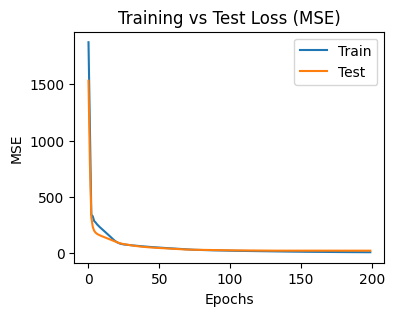

In [10]:
# Візуалізація тренувальних та тестових втрат
plt.figure(figsize=(4, 3))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Training vs Test Loss (MSE)')
plt.show()


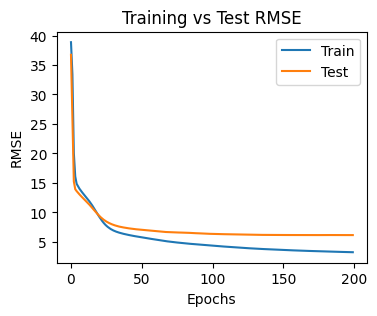

In [11]:
# Візуалізація тренувальних та тестових RMSE
plt.figure(figsize=(4, 3))
plt.plot(train_rmses, label='Train')
plt.plot(test_rmses, label='Test')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training vs Test RMSE')
plt.show()

## Висновки

### Вибір гіперпараметрів

200 епох було вибрано на основі аналізу тренувальних втрат і тестової помилки. Це дозволило досягти стабільного навчання без значного переобучення.

Розмір батчу 32 — це стандартний розмір батчу, який забезпечує баланс між ефективністю навчання і стабільністю оновлень ваг.

Швидкість навчання 5e-4 була обрана після тестування кількох значень. Вона виявилася оптимальною для стабільного зменшення втрат, уникнення переобучення і забезпечення плавної збіжності.

MSELoss була вибрана як функція втрат для задачі регресії, оскільки вона добре підходить для мінімізації великих помилок, які можуть виникати при прогнозуванні неперервних значень, таких як міцність бетону.

### Про навчання моделі

Модель була успішно навчена для задачі прогнозування міцності бетону на основі даних про склад компонентів. Використання нейронної мережі з трьома прихованими шарами (256 → 128 → 64 нейронів) показало стабільні результати. Швидкість навчання, встановлена на рівні 5e-4, забезпечила плавну збіжність без різких стрибків. Навчання тривало протягом 200 епох і тренувальна та тестова криві були досить близькими одна до одної. Це дозволяє зробити висновок, що модель добре навчається і досягає гарної збіжності на тренувальних даних.

### Результати на валідаційній вибірці

Після навчання на валідаційній вибірці були отримані наступні результати:

MSE: 37.8656<br>
MAE: 4.5077<br>
R²: 0.8531<br>

Ці результати демонструють високу точність моделі. Значення MSE вказує на низький рівень середньої помилки у прогнозах, а MAE свідчить про те, що в середньому модель помиляється приблизно на 4.5 одиниць міцності бетону. R² на рівні 0.8531 показує, що модель добре узагальнює дані.

Модель стабільно працювала як на тренувальних, так і на тестових даних, не демонструючи значних ознак переобучення. Невелика різниця між тренувальними та тестовими втратами після 150-ї епохи підтверджує, що модель здатна узагальнювати дані та робити точні прогнози на нових даних.